In [1]:
import sys, os
sys.path.insert(0, '../..')
# os.environ["CUDA_VISIBLE_DEVICES"]=""

os.environ['disable_tqdm'] = 'true'

In [2]:
import numpy as np
import pandas as pd
import torch
from models.weighted_node2vec import WeightedNode2Vec
from dataset import triplet_dataset, pokec_data
from utils.config import DEVICE
import gc
from tqdm import trange
from utils.link_prediction import GCNLinkPrediction
import residual2vec as rv
import warnings
import faiss
import matplotlib.pyplot as plt
from utils.score import statistical_parity
from utils import graph_utils
from utils.snakemake_utils import FileResources
import seaborn as sns
from utils import snakemake_utils
import pickle as pkl
warnings.filterwarnings("ignore")
gc.enable()

/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: cuda:0


In [3]:
! ls /data/sg/ashutiwa/final_crosswalk/airport/airport_one/

airport_adj_crosswalk.npz
airport_adj_fairwalk.npz
airport_adj.npz
airport_crosswalk_deepwalk.npy
airport_crosswalk_node2vec.npy
airport_deepwalk_128_embs.npy
airport_deepwalk.npy
airport_fairwalk_deepwalk.npy
airport_fairwalk_node2vec.npy
airport_gat_None_deepwalk_deepwalk_embs.npy
airport_gat_None_deepwalk_deepwalk.h5
airport_gat_None_deepwalk_r2v_embs.npy
airport_gat_None_deepwalk_r2v.h5
airport_gat_None_node2vec_deepwalk_embs.npy
airport_gat_None_node2vec_deepwalk.h5
airport_gat_None_node2vec_r2v_embs.npy
airport_gat_None_node2vec_r2v.h5
airport_gcn_None_deepwalk_deepwalk_embs.npy
airport_gcn_None_deepwalk_deepwalk.h5
airport_gcn_None_deepwalk_r2v_embs.npy
airport_gcn_None_deepwalk_r2v.h5
airport_gcn_None_node2vec_deepwalk_embs.npy
airport_gcn_None_node2vec_deepwalk.h5
airport_gcn_None_node2vec_r2v_embs.npy
airport_gcn_None_node2vec_r2v.h5
airport_node2vec_128_embs.npy
airport_node2vec.npy
airport_test_adj.npz


In [4]:
y = snakemake_utils.get_dataset("polblog").get_grouped_col()
sp_score, roc_score, gini_score, embs = {}, {}, {}, {}
DATA_ROOT = '/data/sg/ashutiwa/final_crosswalk/polblog/'

DIRS = ['polblog_one/', 'polblog_two/', 'polblog_three/', 'polblog_four/', 'polblog_five/']
DATASET = 'polblog'

model_to_embs = {
    "fairwalk+deepwalk": "_fairwalk_deepwalk.npy",
    "fairwalk+node2vec": "_fairwalk_node2vec.npy",
    "crosswalk+deepwalk": "_crosswalk_deepwalk.npy",
    "crosswalk+node2vec": "_crosswalk_node2vec.npy",
    "GCN+deepwalk+random": "_gcn_None_deepwalk_deepwalk_embs.npy",
    "GCN+deepwalk+r2v": "_gcn_None_deepwalk_r2v_embs.npy",
    "GCN+node2vec+random": "_gcn_None_node2vec_deepwalk_embs.npy",
    "GCN+node2vec+r2v": "_gcn_None_node2vec_r2v_embs.npy",
    "GAT+deepwalk+random": "_gat_None_deepwalk_deepwalk_embs.npy",
    "GAT+deepwalk+r2v": "_gat_None_deepwalk_r2v_embs.npy",
    "GAT+node2vec+random": "_gat_None_node2vec_deepwalk_embs.npy",
    "GAT+node2vec+r2v": "_gat_None_node2vec_r2v_embs.npy",
    "deepwalk": "_deepwalk_128_embs.npy",
    "node2vec": "_node2vec_128_embs.npy"
    
}
M = list(model_to_embs.keys())


TEST_ADJ_FILE='/data/sg/ashutiwa/final_crosswalk/polblog/polblog_one/polblog_test_adj.npz'
NUM_NODES=1224
k=5

# distributions of positive and negative edgeswith dot product

In [5]:
def get_roc_score(df):
    from sklearn.metrics import roc_auc_score
    y_pred = np.concatenate((df.positive_dot.values, df.negative_dot.values))
    y_true = np.concatenate((np.ones_like(df.positive_dot.values), np.zeros_like(df.negative_dot.values)))
    return roc_auc_score(y_true, y_pred)



In [6]:
def plot_dot_(df, title):
#     df = pd.DataFrame({
#         "positive_dot": np.array([np.dot(a[i], p[i]) for i in trange(a.shape[0])]),
#         "negative_dot": np.array([np.dot(a[i], n[i]) for i in trange(a.shape[0])])
#     })
    
#     fig, ax = plt.subplots(1,1)
    df.positive_dot.plot(kind='density', title=title)
    df.negative_dot.plot(kind='density', title=title)
#     ax.set_xlim(-1000, 1000)
    ax.legend(['positive_neighbors', 'negative_neighbors'])
#     fig.show()

In [7]:
FILE_CACHE = {}
def create_dot_df(A, file=TEST_ADJ_FILE):
    """
    A are node embeddings of shape # nodes \times 128
    """
    EDGE_IDX = snakemake_utils.get_edge_index_from_sparse_path(file)
    if file in FILE_CACHE:
        NEGATIVE_EDGE_IDX, EDGE_IDX = FILE_CACHE[file]
    else:
        NEGATIVE_EDGE_IDX, EDGE_IDX = graph_utils._negative_sampling_sparse(edge_index=EDGE_IDX, n_nodes=NUM_NODES, return_pos_samples=True)
        FILE_CACHE[file] = (NEGATIVE_EDGE_IDX, EDGE_IDX)
    print("selected edge_idx size: {}".format(EDGE_IDX.size(1)))

    positive_dot = np.sum(A[EDGE_IDX[0,:]] * A[EDGE_IDX[1,:]], axis=1)
    negative_dot = np.sum(A[NEGATIVE_EDGE_IDX[0,:]] * A[NEGATIVE_EDGE_IDX[1,:]], axis=1)
    dot = pd.DataFrame()
    dot["positive_dot"] = positive_dot
    dot["negative_dot"] = negative_dot
    
    return dot

# deepwalk

In [8]:
model = "deepwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


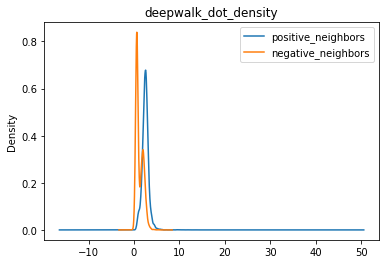

In [9]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [10]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5396.25it/s]


((6098, 2), 0.0049624397904551735, 0.8822264882464834, 0.3017018158192058)

# node2vec

In [11]:
model = "node2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


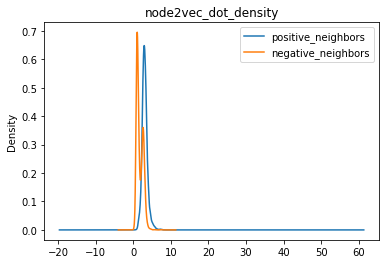

In [12]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [13]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5846.99it/s]


((6114, 2), 0.004788002012810941, 0.8741000070335326, 0.29173630111579957)

# fairwalk+deepwalk

In [14]:
model = "fairwalk+deepwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


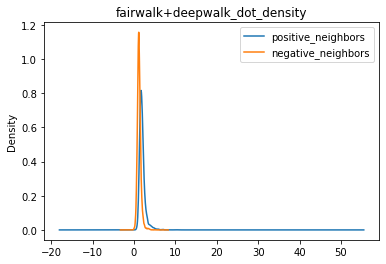

In [15]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [16]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5592.16it/s]


((6116, 2), 0.0035891613682724143, 0.8628900585520842, 0.2335035124326765)

# fairwalk+node2vec

In [17]:
model = "fairwalk+node2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape


(1224, 128)

selected edge_idx size: 12171


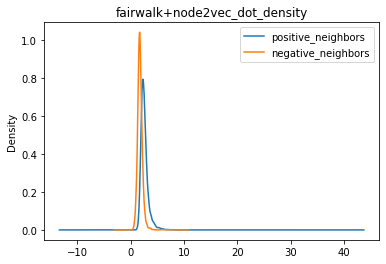

In [18]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [19]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4735.73it/s]


((6120, 2), 0.00399380202163433, 0.8782202166224123, 0.2574928214836161)

# crosswalk+deepwalk

In [20]:
model = "crosswalk+deepwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


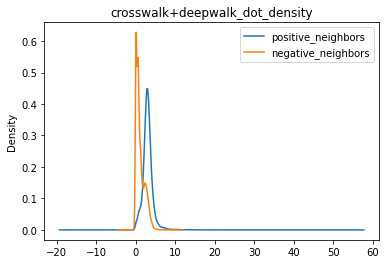

In [21]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [22]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4677.29it/s]


((6120, 2), 0.004591390559726893, 0.8804436203485213, 0.30732754327066814)

# crosswalk+node2vec

In [23]:
model = "crosswalk+node2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


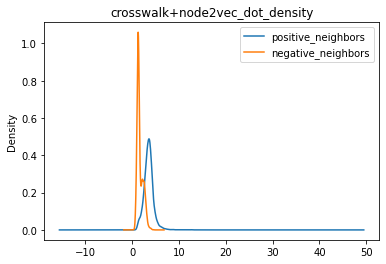

In [24]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [25]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4696.70it/s]


((6112, 2), 0.004743312956736013, 0.9444011692149503, 0.30861906935261485)

# GCN+deepwalk+random

In [26]:
model = "GCN+deepwalk+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


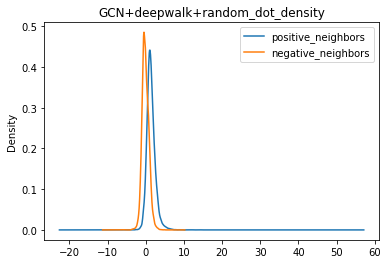

In [27]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [28]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4909.10it/s]


((6120, 2), 0.004428101365870264, 0.8614076735146841, 0.30530767524351926)

# GCN+deepwalk+r2v

In [29]:
model = "GCN+deepwalk+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape


(1224, 128)

selected edge_idx size: 12171


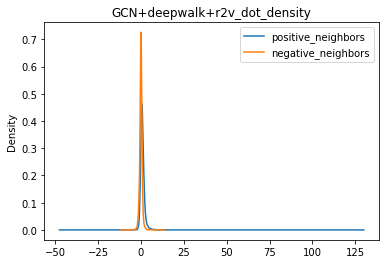

In [30]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [31]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4920.62it/s]


((6120, 2), 0.0029368883061856354, 0.7709986882687594, 0.2192443846388476)

# GCN+node2vec+random

In [32]:
model = "GCN+node2vec+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


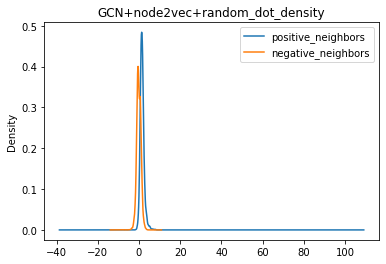

In [33]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [34]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5119.00it/s]


((6120, 2), 0.004421939413204045, 0.8829639763299313, 0.3027934833003082)

# GCN+node2vec+r2v

In [35]:
model = "GCN+node2vec+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


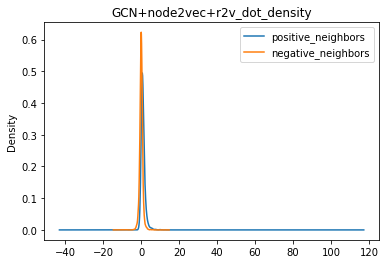

In [36]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [37]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6362.43it/s]


((6120, 2), 0.0026713414280232876, 0.7909289684683265, 0.1966584950474915)

# GAT+deepwalk+random

In [38]:
model = "GAT+deepwalk+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


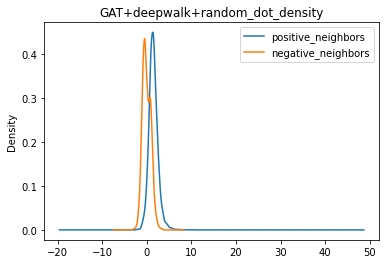

In [39]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [40]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5242.88it/s]


((6120, 2), 0.004401874152207984, 0.867576849277199, 0.3041610006086591)

# GAT+deepwalk+r2v

In [41]:
model = "GAT+deepwalk+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


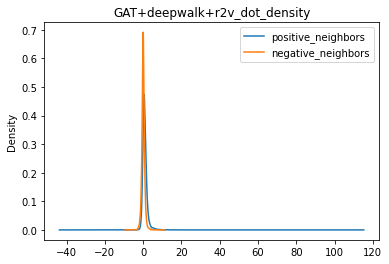

In [42]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [43]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6402.08it/s]


((6120, 2), 0.0028619859080159554, 0.746050948821136, 0.2161623306622445)

# GAT+node2vec+random

In [44]:
model = "GAT+node2vec+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


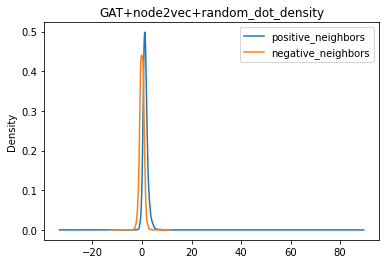

In [45]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [46]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6351.38it/s]


((6120, 2), 0.004354590889076896, 0.8813109813752066, 0.2948641827865031)

# GAT+node2vec+r2v

In [47]:
model = "GAT+node2vec+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


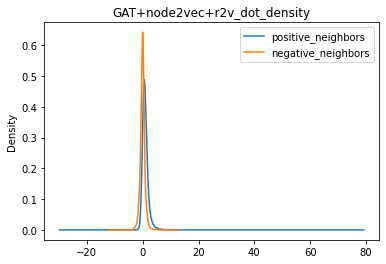

In [48]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [49]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5270.85it/s]


((6120, 2), 0.0028447395240220334, 0.7860170054606447, 0.21190995165478269)

# plot statistical parity scores

# gini sp scores

deepwalk 0.3017018158192058
node2vec 0.29173630111579957
fairwalk+deepwalk 0.2335035124326765
fairwalk+node2vec 0.2574928214836161
crosswalk+deepwalk 0.30732754327066814
crosswalk+node2vec 0.30861906935261485
GCN+deepwalk+random 0.30530767524351926
GCN+deepwalk+r2v 0.2192443846388476
GCN+node2vec+random 0.3027934833003082
GCN+node2vec+r2v 0.1966584950474915
GAT+deepwalk+random 0.3041610006086591
GAT+deepwalk+r2v 0.2161623306622445
GAT+node2vec+random 0.2948641827865031
GAT+node2vec+r2v 0.21190995165478269


Text(0.5, 1.0, 'gini statistical parity scores')

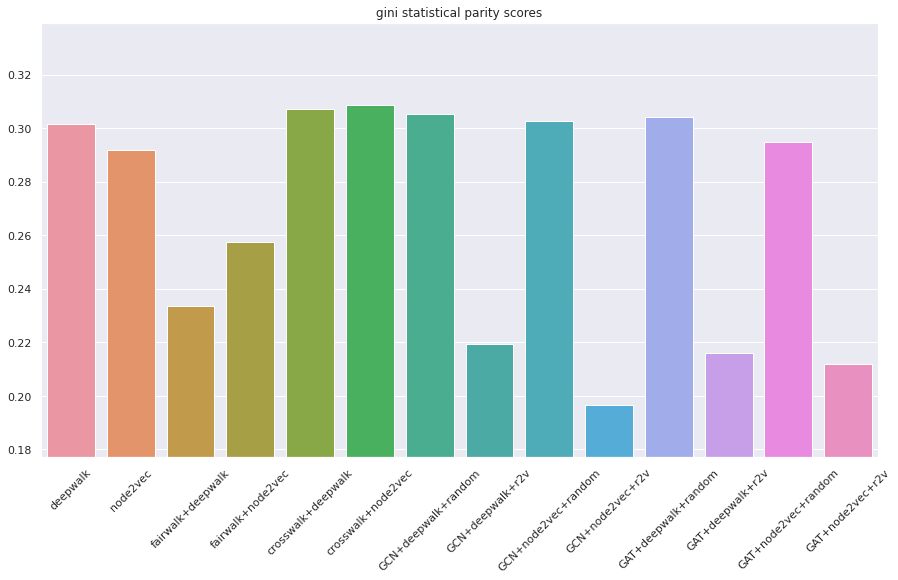

In [50]:

for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()) * .9 , max(gini_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

# sp scores

deepwalk 0.0049624397904551735
node2vec 0.004788002012810941
fairwalk+deepwalk 0.0035891613682724143
fairwalk+node2vec 0.00399380202163433
crosswalk+deepwalk 0.004591390559726893
crosswalk+node2vec 0.004743312956736013
GCN+deepwalk+random 0.004428101365870264
GCN+deepwalk+r2v 0.0029368883061856354
GCN+node2vec+random 0.004421939413204045
GCN+node2vec+r2v 0.0026713414280232876
GAT+deepwalk+random 0.004401874152207984
GAT+deepwalk+r2v 0.0028619859080159554
GAT+node2vec+random 0.004354590889076896
GAT+node2vec+r2v 0.0028447395240220334


Text(0.5, 1.0, 'statistical parity scores')

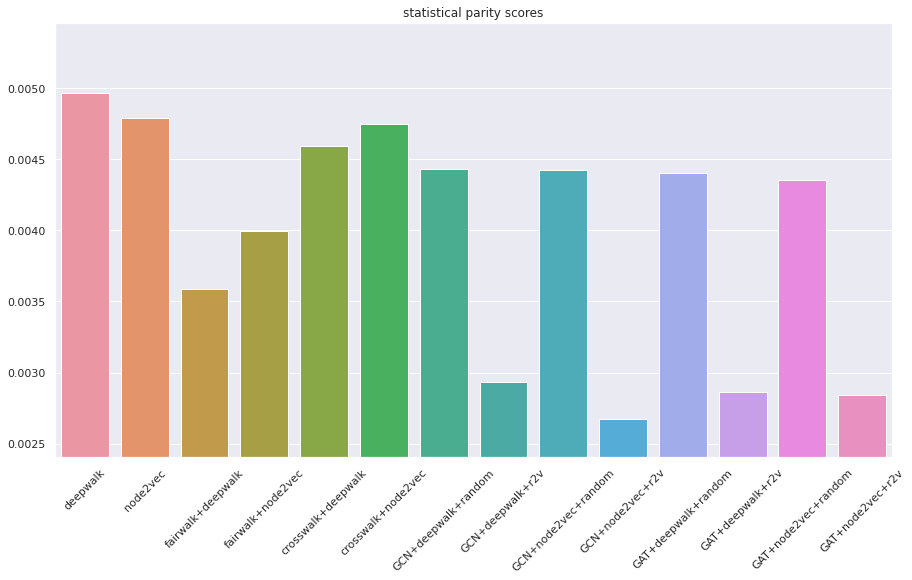

In [51]:

for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

# roc auc scores

deepwalk 0.8822264882464834
node2vec 0.8741000070335326
fairwalk+deepwalk 0.8628900585520842
fairwalk+node2vec 0.8782202166224123
crosswalk+deepwalk 0.8804436203485213
crosswalk+node2vec 0.9444011692149503
GCN+deepwalk+random 0.8614076735146841
GCN+deepwalk+r2v 0.7709986882687594
GCN+node2vec+random 0.8829639763299313
GCN+node2vec+r2v 0.7909289684683265
GAT+deepwalk+random 0.867576849277199
GAT+deepwalk+r2v 0.746050948821136
GAT+node2vec+random 0.8813109813752066
GAT+node2vec+r2v 0.7860170054606447


Text(0.5, 1.0, 'roc scores')

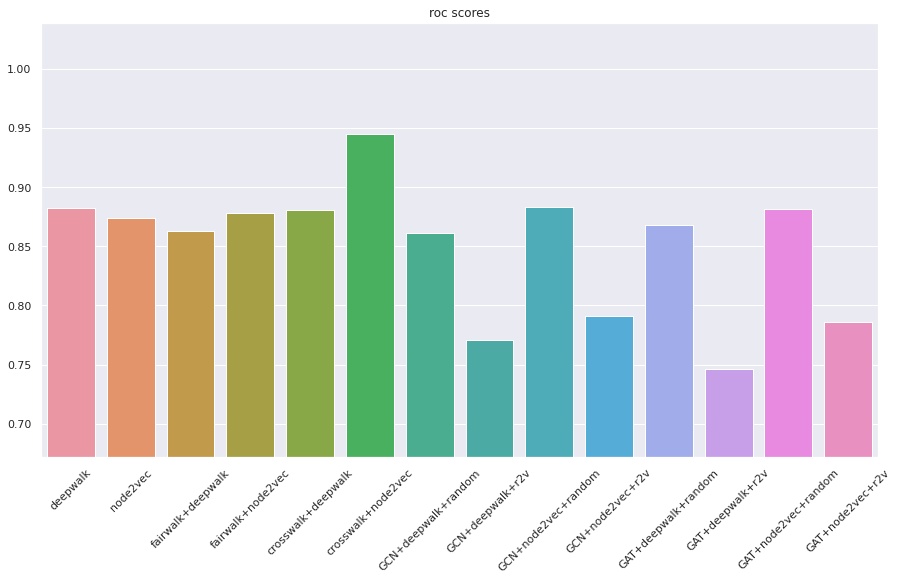

In [52]:

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

In [53]:

N = 20

sp_scores, gini_scores = np.zeros((N, len(M))), np.zeros((N, len(M)))
for k in range(N):
    for idx, m in enumerate(M):
        if k == 0: continue
        batch_size =  2000
        A = embs[m]
        batch_size = 20

        edges = snakemake_utils.return_new_graph(A, k, batch_size)
        
    
        gini_scores[k, idx] = statistical_parity(edges, y, metric='gini')
        sp_scores[k, idx] = statistical_parity(edges, y, )


WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5027.17it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5214.14it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6263.53it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5995.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6230.88it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6220.43it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5908.97it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6225.43it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6260.16it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5217.01it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5258.94it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6385.94it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5590.21it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5614.25it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5626.47it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5423.94it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6128.79it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6084.48it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6006.49it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6521.86it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6267.67it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6294.35it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6260.77it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6283.52it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6076.54it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5556.58it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5345.63it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5859.98it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5656.07it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6085.64it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5851.40it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5793.76it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5966.01it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6077.98it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5758.55it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5983.32it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

Text(0.5, 1.0, 'gini scores vs # nn')

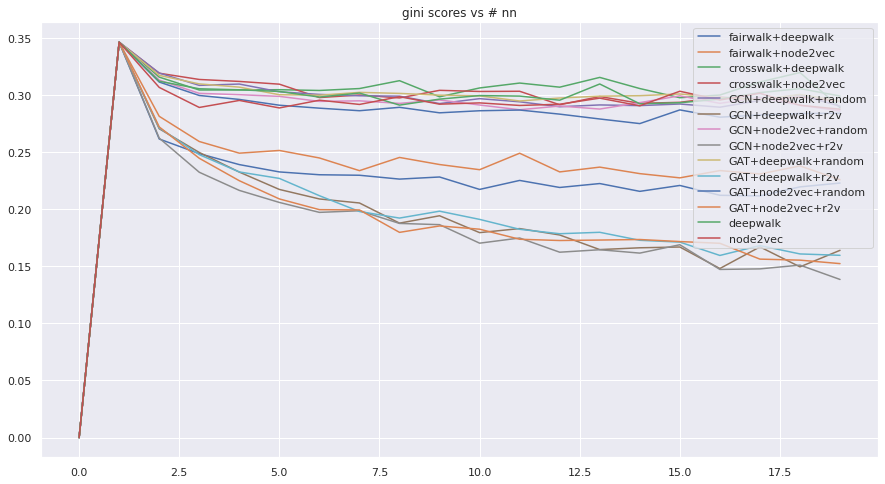

In [54]:
for i in range(len(M)):
    plt.plot(gini_scores[:, i], label=M[i])
plt.legend(loc="upper right")
plt.title("gini scores vs # nn")

Text(0.5, 1.0, 'sp scores vs # nn')

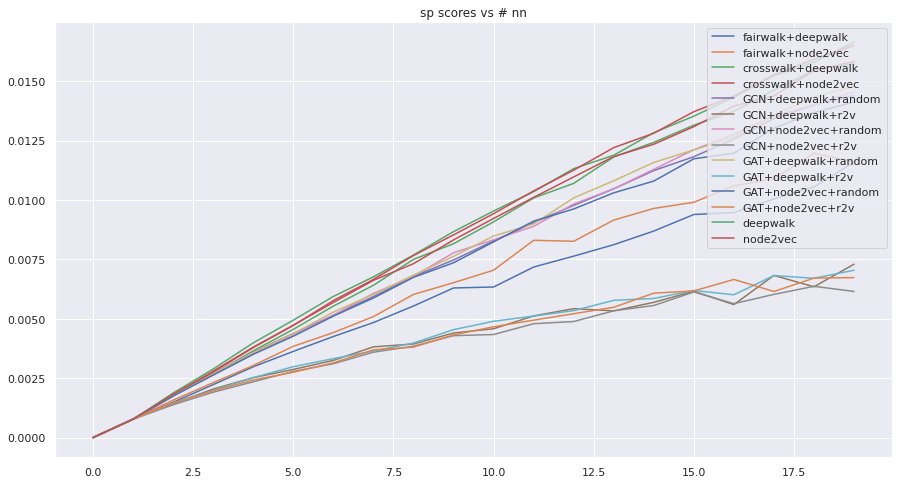

In [55]:
for i in range(len(M)):
    plt.plot(sp_scores[:, i], label=M[i])
plt.legend(loc="upper right")

plt.title("sp scores vs # nn")

# combine all different runs

In [56]:

def roc_scores(model_name):
    scores = np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + model_to_embs[model_name])
        file = DATA_ROOT + d + DATASET + '_test_adj.npz'
        dot = create_dot_df(A, file)
        scores[idx] = get_roc_score(dot)
    return scores


def statisticalp_scores(model_name, K=5):
    scores, scores_gini = np.zeros(len(DIRS)), np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + model_to_embs[model_name])
        batch_size = 20

        edges = snakemake_utils.return_new_graph(A, K, batch_size)
        scores_gini[idx] = statistical_parity(edges, y, metric='gini')
        
        scores[idx] = statistical_parity(edges, y, )
    return scores, scores_gini

selected edge_idx size: 12171
selected edge_idx size: 13101
selected edge_idx size: 12154
selected edge_idx size: 12933
selected edge_idx size: 13027
selected edge_idx size: 12171
selected edge_idx size: 13101
selected edge_idx size: 12154
selected edge_idx size: 12933
selected edge_idx size: 13027
selected edge_idx size: 12171
selected edge_idx size: 13101
selected edge_idx size: 12154
selected edge_idx size: 12933
selected edge_idx size: 13027
selected edge_idx size: 12171
selected edge_idx size: 13101
selected edge_idx size: 12154
selected edge_idx size: 12933
selected edge_idx size: 13027
selected edge_idx size: 12171
selected edge_idx size: 13101
selected edge_idx size: 12154
selected edge_idx size: 12933
selected edge_idx size: 13027
selected edge_idx size: 12171
selected edge_idx size: 13101
selected edge_idx size: 12154
selected edge_idx size: 12933
selected edge_idx size: 13027
selected edge_idx size: 12171
selected edge_idx size: 13101
selected edge_idx size: 12154
selected e

Text(0.5, 1.0, 'roc scores')

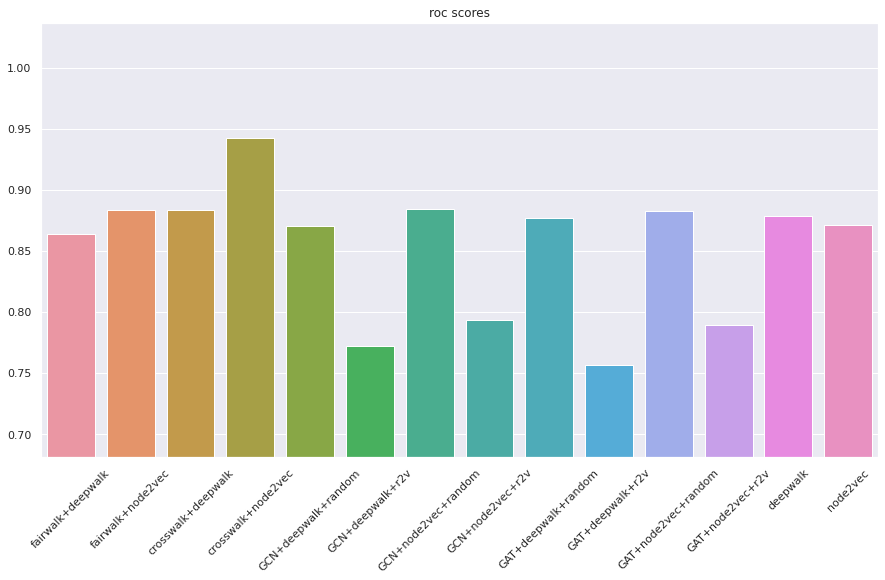

In [57]:

roc_score = {m: np.mean(roc_scores(m)) for m in model_to_embs}

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5076.54it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5235.91it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5605.02it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5400.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6387.05it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6283.37it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6335.18it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6281.52it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5102.15it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4977.68it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6236.66it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6008.89it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

fairwalk+deepwalk 0.0035996222119952953
fairwalk+node2vec 0.003941224636530348
crosswalk+deepwalk 0.004703673513489182
crosswalk+node2vec 0.004652368937969286
GCN+deepwalk+random 0.004469728013074404
GCN+deepwalk+r2v 0.003167077672201508
GCN+node2vec+random 0.004376204376771909
GCN+node2vec+r2v 0.002979754087527057
GAT+deepwalk+random 0.004387704603517525
GAT+deepwalk+r2v 0.002937895828869501
GAT+node2vec+random 0.004355386220216304
GAT+node2vec+r2v 0.0027945603411297865
deepwalk 0.00494496211416216
node2vec 0.004847032765632685


Text(0.5, 1.0, 'statistical parity scores')

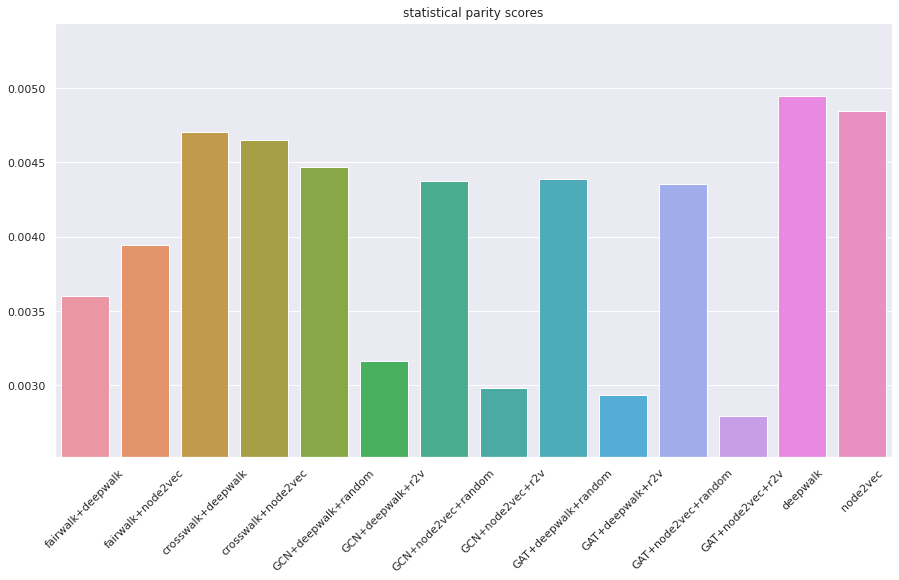

In [58]:

temp = {m: statisticalp_scores(m) for m in model_to_embs}

sp_score = {m: np.mean(v[0]) for m,v in temp.items()}
for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

fairwalk+deepwalk 0.23518540514871383
fairwalk+node2vec 0.25631635802841557
crosswalk+deepwalk 0.30789663832565956
crosswalk+node2vec 0.30247318363523307
GCN+deepwalk+random 0.30643256909709066
GCN+deepwalk+r2v 0.23215002624825928
GCN+node2vec+random 0.30116615616268955
GCN+node2vec+r2v 0.22328960807280973
GAT+deepwalk+random 0.3012555509585632
GAT+deepwalk+r2v 0.21924456085021893
GAT+node2vec+random 0.2989981371977316
GAT+node2vec+r2v 0.21218208596156168
deepwalk 0.30059325251065927
node2vec 0.2970554252501199


Text(0.5, 1.0, 'gini statistical parity scores')

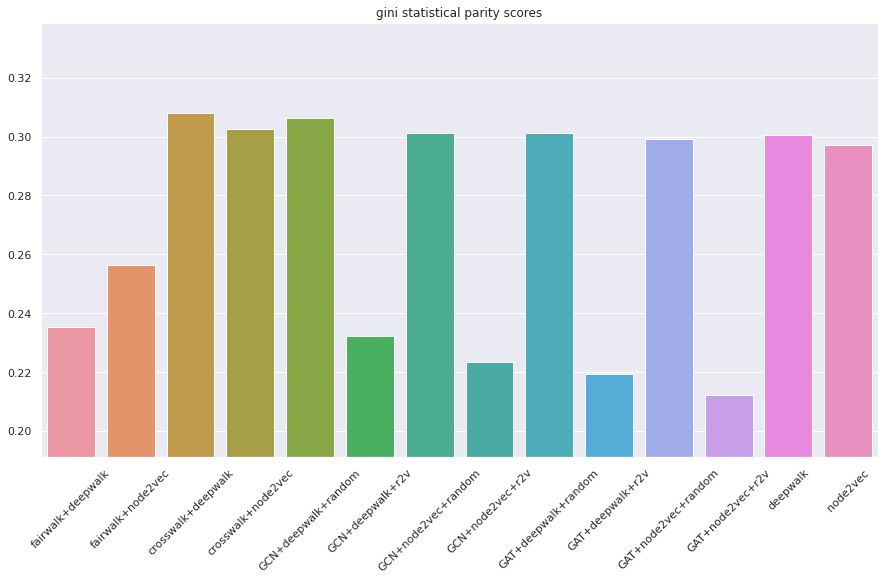

In [59]:
gini_score = {m: np.mean(v[1]) for m,v in temp.items()}
for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()) * .9, max(gini_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

In [60]:

# roc_score, sp_score, gini_score= {}, {}, {}
roc_score = {m: roc_scores(m) for m in model_to_embs}
temp = {m: statisticalp_scores(m) for m in model_to_embs}
sp_score = {m: v[0] for m,v in temp.items()}
gini_score = {m: v[1] for m,v in temp.items()}
pkl.dump(roc_score, open(DATA_ROOT + "roc_score.pkl", 'wb'))

pkl.dump(sp_score, open(DATA_ROOT + "sp_score.pkl", 'wb'))

pkl.dump(gini_score, open(DATA_ROOT + "gini_score.pkl", 'wb'))

selected edge_idx size: 12171
selected edge_idx size: 13101
selected edge_idx size: 12154
selected edge_idx size: 12933
selected edge_idx size: 13027
selected edge_idx size: 12171
selected edge_idx size: 13101
selected edge_idx size: 12154
selected edge_idx size: 12933
selected edge_idx size: 13027
selected edge_idx size: 12171
selected edge_idx size: 13101
selected edge_idx size: 12154
selected edge_idx size: 12933
selected edge_idx size: 13027
selected edge_idx size: 12171
selected edge_idx size: 13101
selected edge_idx size: 12154
selected edge_idx size: 12933
selected edge_idx size: 13027
selected edge_idx size: 12171
selected edge_idx size: 13101
selected edge_idx size: 12154
selected edge_idx size: 12933
selected edge_idx size: 13027
selected edge_idx size: 12171
selected edge_idx size: 13101
selected edge_idx size: 12154
selected edge_idx size: 12933
selected edge_idx size: 13027
selected edge_idx size: 12171
selected edge_idx size: 13101
selected edge_idx size: 12154
selected e

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5937.08it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5860.92it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6111.22it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6054.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6289.08it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6224.67it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5883.83it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6212.27it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5638.00it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6421.20it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6060.99it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6210.92it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training